# Tutorial on Convex.jl (Convex Optimization in Julia)

## Example 1: Least-Squares Curve Fitting

$\tt Convex.jl$ is a Julia-embedded modeling language for (disciplined) convex optimization problems. Much like CVX in MATLAB or CVXPY in Python, it allows you to express the problem in a natural way that follows the math, instead of expressing the problem in a way that conforms to a specific solver's syntax. For more details and advanced usage of $\tt Convex.jl$, please see [the documentation](https://jump.dev/Convex.jl/stable/).

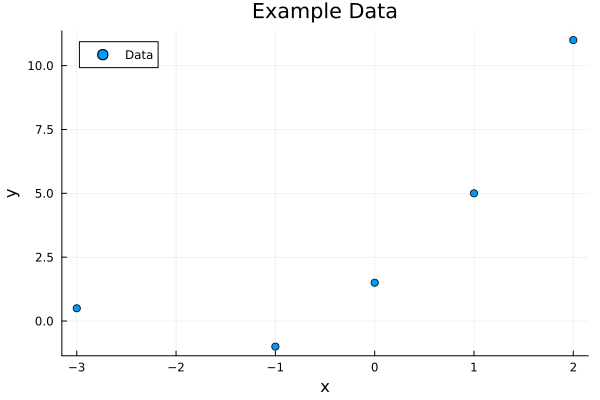

In [6]:
# Uncomment if running for the first time
# using Pkg 
# Pkg.add("Convex")
# Pkg.add("Plots")
# Pkg.add("ECOS")

using Convex # Import Convex.jl
using ECOS   # optimizer
using Plots  # For visualization


# Define some data
x = [-3, -1, 0, 1, 2]
y = [0.5, -1, 1.5, 5, 11]

# Plot the data
p = scatter(x, y, label="Data")
xlabel!(p, "x")
ylabel!(p, "y")
title!(p, "Example Data")

The data look like they follow a quadratic function. We can set up the following Vandermonde system and use unconstrained least-squares to estimate parameters for a quadratic function.

$$A = \begin{bmatrix} 1 & x_0 & x_0^2 \\ 1 & x_1 & x_1^2 \\ 1 & x_2 & x_2^2 \\ 1 & x_3 & x_3^2 \\ 1 & x_4 & x_4^2 \end{bmatrix} $$

Solving the following least-squares problem for $\beta$ will give us parameters for a quadratic model:

$$\min_{\beta} \lVert A\beta - y \rVert_2 $$



In [7]:
# Define A matrix
A = [ones(5, 1) x x.^2]

# Define Convex variable
β = Variable(3)

# define objective function
objective = norm(A*β - y)

# setup solver
solver = ECOS.Optimizer

# define problem
problem = minimize(objective)

# solve 
Convex.solve!(problem, solver)

@show β.value

β.value = [1.2385861561126557; 3.0165684830626103; 0.9215758468332297;;]

ECOS 2.0.8 - (C) embotech GmbH, Zurich Switzerland, 2012-15. Web: www.embotech.com/ECOS

It     pcost       dcost      gap   pres   dres    k/t    mu     step   sigma     IR    |   BT
 0  +0.000e+00  -0.000e+00  +9e+00  2e-01  3e-04  1e+00  5e+00    ---    ---    1  1  - |  -  - 
 1  +2.472e-02  +2.512e-02  +4e-01  1e-02  1e-05  4e-02  2e-01  0.9555  1e-04   2  1  1 |  0  0
 2  +3.344e-01  +3.464e-01  +5e-02  1e-03  1e-06  2e-02  3e-02  0.9262  7e-02   2  2  2 |  0  0
 3  +3.494e-01  +3.496e-01  +5e-04  2e-05  2e-08  2e-04  4e-04  0.9890  1e-04   2  1  1 |  0  0
 4  +3.496e-01  +3.496e-01  +6e-06  2e-07  2e-10  2e-06  4e-06  0.9890  1e-04   2  1  1 |  0  0
 5  +3.496e-01  +3.496e-01  +6e-08  2e-09  2e-12  3e-08  4e-08  0.9890  1e-04   2  1  1 |  0  0
 6  +3.496e-01  +3.496e-01  +7e-10  2e-11  2e-14  3e-10  5e-10  0.9890  1e-04   2  1  1 |  0  0

OPTIMAL (within feastol=2.2e-11, reltol=1.9e-09, abstol=6.8e-10).
Ru

┌ Info: [Convex.jl] Compilation finished: 0.0 seconds, 60.312 KiB of memory allocated
└ @ Convex /Users/jensrataczak/.julia/packages/Convex/5ZBPt/src/solution.jl:107


3×1 Matrix{Float64}:
 1.2385861561126557
 3.0165684830626103
 0.9215758468332297

Let's check the solution to see how we did:

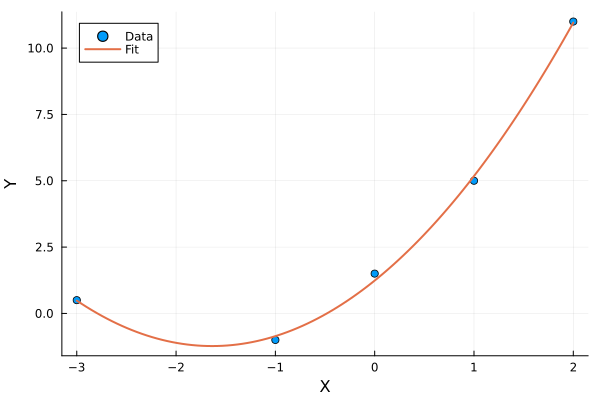

In [8]:
_β = β.value
_x = collect(range(minimum(x), maximum(x), 100))
_y = _β[1]*ones(100) + _β[2]*_x + _β[3]*_x.^2

p = scatter(x, y, label="Data")
plot!(p, _x, _y, label="Fit", linewidth=2)
xlabel!("X")
ylabel!("Y")

## Example 2: L1-Norm Minimization

Consider the basis pursuit problem

$$ \begin{align}
   \min_x \quad& \lVert x \rVert _1 \\
   \textrm{s.t} \quad&  Ax = y
   \end{align}
   $$

This is a least L1-norm problem that will hopefully yield a sparse solution $x$.

This problem now has both an objective, $\lVert x \rVert _1$, and an affine equality constraint $Ax=y$. 

In [9]:
using Random
# make a bogus sparse solution and RHS
m = 200; n = 100;
A = randn(m, n)

_x = zeros(n)  # just using this notation to show that this is something we're going to pretend we don't actually have
_k = 10
_I = randperm(n)[1:_k]

_x[_I] .= randn(_k)
y = A*_x 

# setup Convex
x = Variable(n)

objective = norm(x, 1)

constraints = Constraint[A*x == y]

problem = minimize(objective, constraints)

Convex.solve!(problem, solver, silent=true)

println("True nonzero inds:      ", sort(_I))
println("Recovered nonzero inds: ", sort(findall(>(1e-14), abs.(evaluate(x)))))
err = norm(evaluate(x) -_x)
println("Norm of error, ||x-x_est|| is $(err)")

True nonzero inds:      [2, 8, 18, 21, 40, 41, 44, 48, 64, 96]
Recovered nonzero inds: [2, 8, 18, 21, 40, 41, 44, 48, 64, 96]
Norm of error, ||x-x_est|| is 1.3279815153226402e-15
